In [1]:
import numpy as np
from fish.ephys import ephys
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('npg')
from skimage import io
import os
import pandas as pd
%matplotlib inline

In [2]:
def prepare_swim(swims, threshold=False):
    from numpy import percentile
    from fish.ephys.ephys import windowed_variance, estimate_threshold
    from skimage.exposure import rescale_intensity
    swim_flt = [windowed_variance(s, kern_mean=None, kern_var=None)[0] for s in swims]        
    ts = (swim_flt[0] + swim_flt[1])
    ts = ts.clip(max = np.percentile(ts, 99.99))
    ts = rescale_intensity(ts, out_range=(0,1))
    ts_thr = ts.copy()
    th = estimate_threshold(ts)
    ts_thr[ts_thr < th] = 0
    return ts, ts_thr
    
    return ts

def prp_data(data, fs_ep = 6000, fused_roi = True, threshold=False, channels=[0,1]):
    from fish.ephys.ephys import chop_trials, windowed_variance
    from scipy.signal import fftconvolve, gaussian
    from numpy import array
    processed = {}
    
    swims = data[0:2].copy()        
    laser_signal = data[6].copy()
    trial_signal = data[4].copy()
        
    swim_pow, swim_pow_thr = prepare_swim(swims[channels])    
    
    kern_smooth = gaussian(6 * fs_ep, 1 * fs_ep)
    kern_smooth /= kern_smooth.sum()
    swim_pow_smooth = fftconvolve(swim_pow, kern_smooth, mode='same')
     
    processed['laser_signal'] = laser_signal
    processed['trial_signal'] = trial_signal
    processed['swims'] = swims
    processed['swim_power'] = swim_pow
    processed['swim_power_thr'] = swim_pow_thr
    processed['swim_power_smoothed'] = swim_pow_smooth
    
    laser = chop_trials(laser_signal)
    on_val = max(list(laser.keys()))

    if fused_roi:
        for val in np.arange(2, len(np.unique(trial_signal)), 2):
            trial_signal[trial_signal == val] = val-1
        
    rois = chop_trials(trial_signal)
    rois.pop(0.0)
    conds = [int(x) for x in rois]
    processed['stim_dur'] = np.median(rois[1][1] - rois[1][0])
    processed['conds'] = conds
    processed['trials'] = rois

    return processed

In [3]:
pos_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/'
neg_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/neg/'
rejected_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/rejected_data/'
proc_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/'

In [4]:
# 'ch' : [0,1] means use channels 0 and 1; 'ch : [0,0] means use 2 copies of channel 0;
exp_params = {}
exp_params['20170316_1_3_gfapcochr_rgeco_g1_6dpf_opto_OMR'] = [0,0]
exp_params['20170320_2_6_g1_r1_7dpf_laser65'] = [0,1]
exp_params['20170321_1_3_g1_r1_6dpf_laser65_20ms'] = [0,1]
exp_params['20170324_7dpf_cy252xcy293_g1_f1_omr_opto_2'] = [1,1]
exp_params['20170324_7dpf_cy252xcy293_g1_f2_omr_opto_1'] = [0,1]
exp_params['20170324_7dpf_cy252xcy293_g1_f3_omr_opto_2'] = [0,1]
exp_params['20170330_6dpf_cy252xcy293_g1_f1_omr_opto_1'] = [0,0]
exp_params['20170330_6dpf_cy252xcy293_gx_f2_omr_opto_2_laser6'] = [0,1]
exp_params['20170331_f1_g1_7dpf_6'] = [1,1]
exp_params['20170404_6dpf_cy252xcy293_f1_g1_omr_opto_1'] = [0,1]
exp_params['20170404_6dpf_cy252xcy293_f4_g1_omr_opto_1'] = [0,1]
exp_params['20170404_6dpf_cy252xcy293_f5_g1_omr_opto_2'] = [0,1]
exp_params['20170404_6dpf_cy252xcy293_f6_g1_omr_opto_2'] = [0,1]
exp_params['20170405_7dpf_cy252xcy293_f1_g1_omr_opto_1'] = [0,1]
exp_params['20170405_7dpf_cy252xcy293_f2_g1_omr_opto_1'] = [0,1]
exp_params['20170319_1_1_g0_r0_6dpf'] = [1,1]
exp_params['20170319_2_2_g0_r0_6dpf_laser6'] = [1,0]
exp_params['20170322_7dpf_cy252xcy293_g0_f3_omr_opto_2'] = [1,1]
exp_params['20170406_6dpf_cy252xcy293_f1_g0_omr_opto_1'] = [0,1]
exp_params['20170419_5dpf_cy252xcy293_f3_g0_omr_opto_1'] = [0,1]

In [5]:
# Load raw data into dataframe
fnames = []

for fn in sorted(glob(proc_dir + 'pos/*/*.10chFlt')):
    exp_name = fn.split(os.path.sep)[-1].split('.')[0]
    genotype = 'pos'
    fnames.append(dict(path=fn, genotype=genotype, exp_name=exp_name, channels=exp_params[exp_name], data=ephys.load(fn, memmap=True)))

for fn in sorted(glob(proc_dir + 'neg/*/*.10chFlt')):
    exp_name = fn.split(os.path.sep)[-1].split('.')[0]
    genotype = 'neg'
    fnames.append(dict(path=fn, genotype=genotype, exp_name=exp_name, channels=exp_params[exp_name], data=ephys.load(fn, memmap=True)))

df = pd.DataFrame(fnames, index=list(map(lambda v: v['exp_name'], fnames)))

Data needed to be truncated!
Data needed to be truncated!


In [6]:
%%time
# only consider trials falling between (2 minutes, 20 minutes) after experiment start
ep_window = slice(0, 6000 * 1210)
prepped = [prp_data(df.loc[x]['data'][:,ep_window], channels=df.loc[[x]]['channels']) for x in df.index]

CPU times: user 1min 5s, sys: 23.4 s, total: 1min 28s
Wall time: 1min 36s


In [7]:
prepped_df = pd.DataFrame(prepped, index=df.index)
prepped_df['genotype'] = df['genotype']

In [8]:
# Generate trial averages for each fish

fs_ep = 6000
ds_ep = 1
window = np.arange(-fs_ep * 5, fs_ep * 15, ds_ep)

def trial_window(data, condition, window):    
    trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
    return data['swim_power_smoothed'][trials]
   
tr_means = {}
genotypes = ['pos', 'neg']
conditions = [1.0, 3.0]
for g in genotypes:
    tr_means[g] = {}
    for c in conditions:
        tr_means[g][c] = {}
        tr_means[g][c] = np.array([np.median(trial_window(data[1], c, window),0) for data in prepped_df[prepped_df.genotype==g].iterrows()]).T;
        stim = np.where(window > 0)[0][0]
        tr_means[g][c] /= tr_means[g][c][:stim,:].mean(0);

tr_means = pd.DataFrame(tr_means)

In [9]:
powers = []
conds = [1.0, 3.0]
wl = 18000
offset = 0
for ind in prepped_df.index:
    exp = prepped_df.loc[ind]
    powers_ = {}
    for c in conds:
        powers_[c] = {}
        powers_[c]['pre'] = np.array([exp['swim_power_thr'][slice(x - wl, x)].mean() for x in exp['trials'][c][0]])
        powers_[c]['post'] = np.array([exp['swim_power_thr'][slice(x+offset, x + wl+offset)].mean() for x in exp['trials'][c][1]])
    powers.append(powers_)
powers = pd.DataFrame(powers, index=prepped_df.index)
powers['genotype'] = prepped_df['genotype']

In [10]:
pooled_powers = {}
genotypes = ['pos', 'neg']
conditions = [1.0, 3.0]
epochs = ['pre', 'post']
for g in genotypes:
    pooled_powers[g] = {}
    for c in conditions:
        pooled_powers[g][c] = {}
        for ep in epochs:
            pooled_powers[g][c][ep] = []
            [pooled_powers[g][c][ep].extend(p[ep]) for p in powers[prepped_df['genotype'] == g][c]]

pooled_powers = pd.DataFrame(pooled_powers)

## Show power per fish before and after stimulation, compute a p-value comparing change in mean of the distribution before and after stimulation

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Text(0,0.5,'gfap:RGECO')

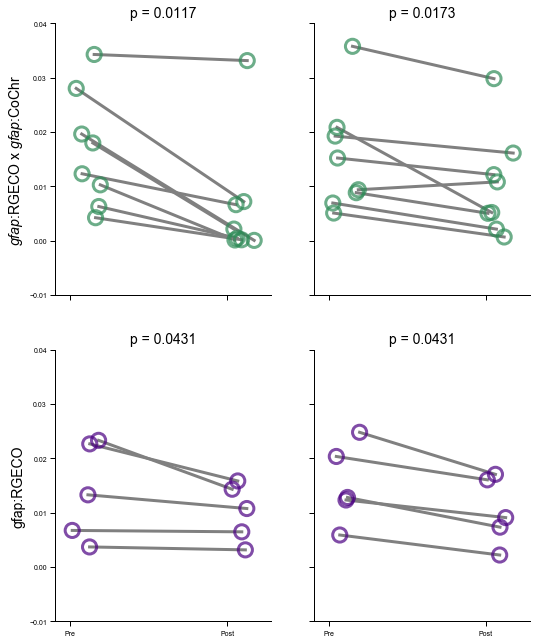

In [11]:
from scipy.stats import wilcoxon
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(8.5,11), sharey=True, sharex=True)
pre_post = {}
gens = ['pos', 'neg']
conds = [1.0, 3.0]
colors = ['seagreen', 'indigo']
axs_titles = ['$gfap$:RGECO x $gfap$:CoChr', 'gfap:RGECO']
jit_std = .2
jit_shift = 1
for ind_g, g in enumerate(gens):
    for ind_c, c in enumerate(conds):
        pre_post[g] = [(np.median(x['pre']), np.median(x['post'])) for x in powers[powers['genotype'] == g][c]]
        pp = list(zip(*pre_post[g]))
        sig = wilcoxon(pp[0], pp[1]).pvalue
        jit = [np.random.random(len(pre_post[g])) * jit_std, jit_shift + np.random.random(len(pre_post[g])) * jit_std]
        ax = axs[ind_g][ind_c]
        ax.scatter(jit[0], pp[0], edgecolors=colors[ind_g], s=200, alpha=.7, facecolors='none', linewidth=3)
        ax.scatter(jit[1], pp[1], edgecolors=colors[ind_g], s=200, alpha=.7, marker='o', facecolors='none', linewidth=3)
        ax.plot(jit, pp, color=(.5,.5,.5), zorder=0, linewidth=3)
        ax.set_title('p = {0}'.format(np.round(sig, 4)), fontsize=14)
        ax.set_xticks([0,1])
        ax.set_xticklabels(['Pre','Post'])
        ax.set_ylim(-.01, .04)

axs[0][0].set_ylabel(axs_titles[0], fontsize=14)
axs[1][0].set_ylabel(axs_titles[1], fontsize=14)
#plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_statistics.pdf')

In [12]:
# similar representation as above, except plot normalized waist stim vs normalized ear stim

## Scatter plot showing percentage change in swimpower in ear stim vs n4 stim

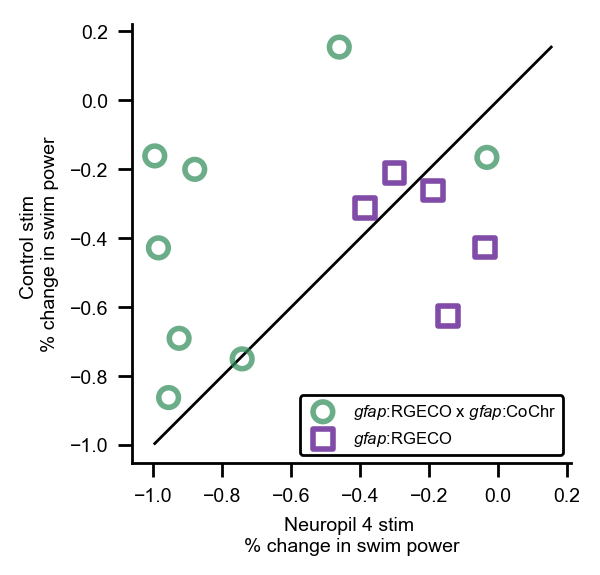

In [21]:
from scipy.stats import wilcoxon
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(8.5 / 3, 11  / 3), sharey=True, sharex=True, dpi=200)

pre_post = {}
gens = ['pos', 'neg']
conds = [1.0, 3.0]
colors = ['seagreen', 'indigo']
markers = ['o', 's']
cond_titles = {1.0 : 'Neuropil 4 stim \n% change in swim power', 3.0 : 'Control stim \n% change in swim power'}
axs_titles = ['$gfap$:RGECO x $gfap$:CoChr', '$gfap$:RGECO']

for ind_g, g in enumerate(gens):
    for ind_c, c in enumerate(conds):
            pre_post[c] = [((-np.median(x['pre']) + np.median(x['post']))  /  np.median(x['pre'])) for x in powers[powers['genotype'] == g][c]]
    
    axs.scatter(pre_post[conds[0]], 
                pre_post[conds[1]], 
                edgecolors=colors[ind_g], 
                s=50, 
                alpha=.7, 
                facecolors='none', 
                linewidth=2, 
                marker=markers[ind_g], 
                label = axs_titles[ind_g])
mn, mx = min([col.get_offsets().min() for col in axs.collections]), max([col.get_offsets().max() for col in axs.collections])
axs.plot([mn, mx], [mn, mx], zorder=0, color='k')
axs.set_ylim(mn, mx)
axs.set_xlim(mn, mx)
axs.axis('square')
axs.set_xlabel(cond_titles[1.0])
axs.set_ylabel(cond_titles[3.0])
axs.legend(loc=4, fontsize=6, framealpha=1, edgecolor='k')
plt.savefig('/groups/ahrens/ahrenslab/davis/data/ngm/opto_stim_scatter.pdf')

## double-distribution plot

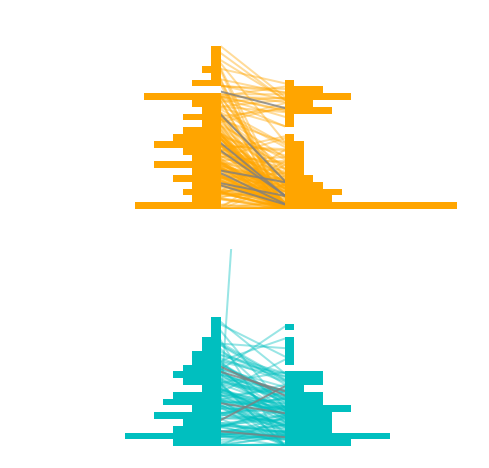

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,8), sharey='row', gridspec_kw = dict(width_ratios=(3,1,3)))
axs[0][0].invert_xaxis()
axs[1][0].invert_xaxis()
plt.subplots_adjust(wspace = 0)
conds = [1.0]
colors = {'neg' : 'c', 'pos' : 'orange'}
for idx, ind in enumerate(prepped_df.index):
    gen = df.loc[ind]['genotype']
    row = axs[0]

    if  gen == 'neg':
        row = axs[1]    
    
    exp = prepped_df.loc[ind]          
    powr = powers.loc[ind] 
    for c in conds:
        x = [np.zeros(len(powr.loc[c]['pre'])),1 + np.zeros(len(powr.loc[c]['pre']))]
        y = [powr.loc[c]['pre'], powr.loc[c]['post']]
        row[1].plot(x, y, alpha=.4, color=colors[gen], linewidth=2)
        row[1].plot(list(map(np.mean, x)), list(map(np.mean, y)), alpha=.8, color=[.5,.5,.5], linewidth=2, zorder=200)
    row[1].set_ylim(0, .06)
    row[1].set_xlim(0, 1)
    row[1].axis('off')
    row[0].axis('off')
    row[-1].axis('off')
    row[0].hist(powr.loc[c]['pre'][~np.isnan(powr.loc[c]['pre'])], np.linspace(0, .06, 30), orientation='horizontal', color=colors[gen])    
    row[-1].hist(powr.loc[c]['post'][~np.isnan(powr.loc[c]['post'])], np.linspace(0, .06, 30), orientation='horizontal', color=colors[gen])
    
    row[0].set_xlim((20, 0))
    row[-1].set_xlim((0, 20))

In [15]:
def raster_plot(data, fs_ep=6000):  
    to_compare = [1,3]
    fig, axs = plt.subplots(nrows=2 + len(to_compare), figsize=(8,12))
    ds_ep = 100
    window = np.arange(-fs_ep * 5, fs_ep * 8, ds_ep)
    onset = np.where(window >= 0)[0][0]
    
    axs[0].plot(data['swims'][0][::15], alpha=.7)
    axs[0].plot(-data['swims'][1][::15], alpha=.7)
    axs[0].axis('tight')    
    
    
    for ind, condition in enumerate(to_compare):    
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        to_plot = data['swim_power'][trials]                            
        tr_mean = to_plot.mean(0)
        # rescale pre-stimulus swims to mean = 1
        #tr_mean /= tr_mean[:onset].mean()        
        clims = (to_plot.min(), to_plot.max())
        # plot the whole recording, both channels        
        axs[1 + ind].imshow(to_plot, cmap='gray_r', interpolation='None', extent=(window[0] / fs_ep, window[-1] / fs_ep, to_plot.shape[0], 0), aspect='auto', clim=clims)
        axs[1 + ind].set_ylabel('ROI {0}'.format(condition))    
        
        axs[-1].plot(window/ fs_ep, tr_mean)
        axs[-1].axis('tight')
        
    return axs

In [16]:
def stackline(data, ds_ep=100):
    from scipy.signal import decimate
    to_compare = [1,3]
    fs_ep = 6000
    stim_dur = data['stim_dur']
    fig, axs = plt.subplots(nrows=len(to_compare), sharex=True, figsize=(8.5 / 2 ,11 / 2), dpi=300)
    window = np.arange(-fs_ep * 3, fs_ep * 6)
    x_axis = window  / fs_ep
    onset = np.where(window >= 0)[0][0]
    
    for ind, condition in enumerate(to_compare):    
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        to_plot = data['swim_power'][trials]                            
        to_plot = decimate(to_plot, q=ds_ep, ftype='fir')
        axs[ind].plot(x_axis[::ds_ep], 2 * to_plot.T + np.arange(to_plot.shape[0]), color='k')
        
        axs[ind].axvspan(0, (stim_dur / fs_ep), alpha=.7, color='c')
        axs[ind].set_ylabel('ROI {0}'.format(condition))
        axs[ind].set_xlim(x_axis[[0,-1]])
    axs[-1].set_xlabel('Time since stimulation (s)')
    return axs

In [17]:
prepped_df.index

Index(['20170316_1_3_gfapcochr_rgeco_g1_6dpf_opto_OMR',
       '20170324_7dpf_cy252xcy293_g1_f1_omr_opto_2',
       '20170324_7dpf_cy252xcy293_g1_f3_omr_opto_2',
       '20170330_6dpf_cy252xcy293_g1_f1_omr_opto_1',
       '20170330_6dpf_cy252xcy293_gx_f2_omr_opto_2_laser6',
       '20170331_f1_g1_7dpf_6', '20170405_7dpf_cy252xcy293_f1_g1_omr_opto_1',
       '20170405_7dpf_cy252xcy293_f2_g1_omr_opto_1', '20170319_1_1_g0_r0_6dpf',
       '20170319_2_2_g0_r0_6dpf_laser6',
       '20170322_7dpf_cy252xcy293_g0_f3_omr_opto_2',
       '20170406_6dpf_cy252xcy293_f1_g0_omr_opto_1',
       '20170419_5dpf_cy252xcy293_f3_g0_omr_opto_1'],
      dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b23d8887ef0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2b23d7e1bb38>], dtype=object)

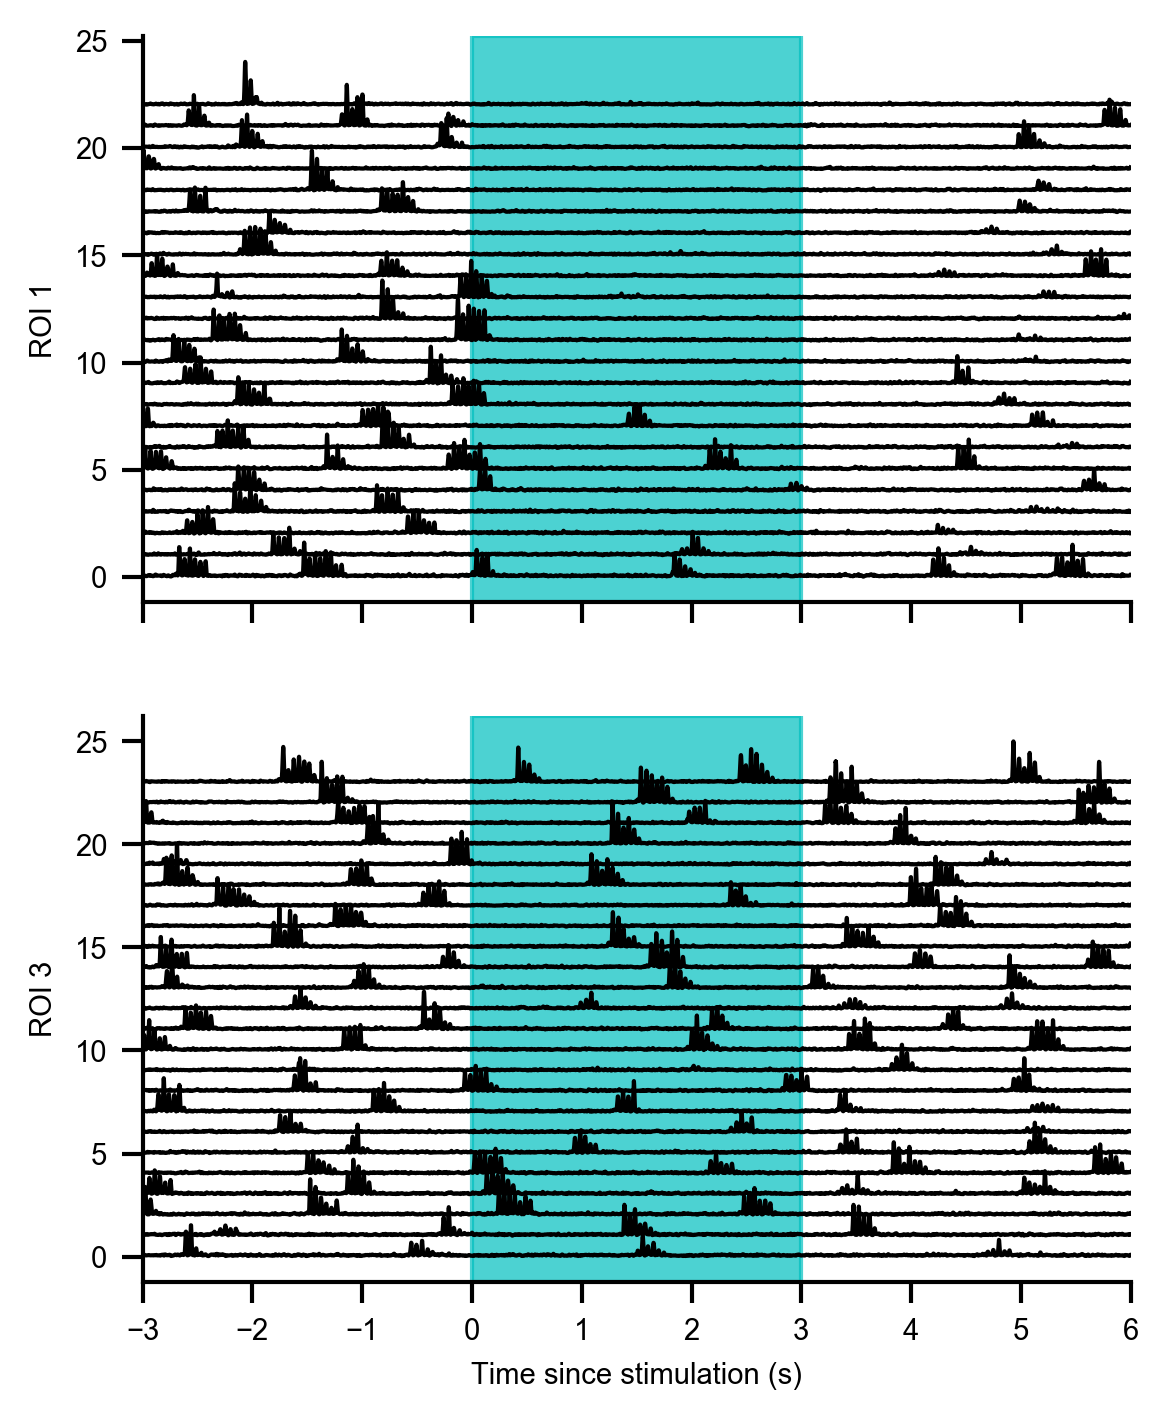

In [18]:
stackline(prepped_df.loc['20170330_6dpf_cy252xcy293_g1_f1_omr_opto_1'], ds_ep=10)

In [19]:
raster_plot()

TypeError: raster_plot() missing 1 required positional argument: 'data'

In [ ]:
for exp in prepped_df.index:
    axs = stackline(prepped_df.loc[exp])
    axs[0].title.set_text(exp)

## Generate the average timeseries plot

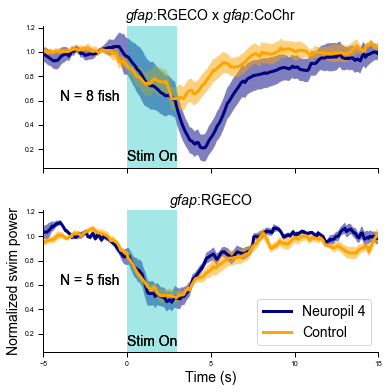

In [16]:
from scipy.stats import sem
fontsize = 14
conds = [1.0, 3.0]
axs_titles = ['$gfap$:RGECO x $gfap$:CoChr', '$gfap$:RGECO']
gens = ['pos', 'neg']
colors = {1.0 : 'navy', 3.0 : 'orange'}
cond_titles = {1.0 : 'Neuropil 4', 3.0 : 'Control'}
fig, axs = plt.subplots(nrows=2, figsize=(6,6), sharey=True, sharex=True)
ds = 10
x_axis = window[::ds] / fs_ep

for ind_g, g in enumerate(gens):    
    for ind_c, c in enumerate(conds):
        cur_axs = axs[ind_g]        
        av = np.median(tr_means[g][c],1)[::ds]        
        err = sem(tr_means[g][c], 1)[::ds]
        err_bounds = (av - err, av + err)
        
        pts_x = np.hstack([x_axis[::-1], x_axis])
        pts_y = np.hstack([err_bounds[0][::-1], err_bounds[1]])
        
        cur_axs.plot(x_axis, av, linewidth=3, color=colors[c], label=cond_titles[c])                
        cur_axs.fill_between(x_axis, *err_bounds, facecolor=colors[c], alpha=.5, edgecolor=None)
        cur_axs.set_xlim((x_axis[0],x_axis[-1]))
        cur_axs.axvspan(0,3, color='c', alpha=.2, linewidth=0)        
        cur_axs.text(-4, .6, 'N = {0} fish'.format(tr_means[g][c].shape[1]), fontsize=fontsize)
        cur_axs.text(0, .1, 'Stim On', fontsize=fontsize)
        cur_axs.title.set_text(axs_titles[ind_g])
        cur_axs.title.set_fontsize(fontsize)
        cur_axs.set_xticks(range(-5, 20, 5))
        

axs[-1].set_xlabel('Time (s)', fontsize=fontsize)
axs[-1].set_ylabel('Normalized swim power', fontsize=fontsize)
axs[-1].legend(fontsize=fontsize)
plt.subplots_adjust(hspace=0.3)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_group_timeseries.pdf')